<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#개요" data-toc-modified-id="개요-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>개요</a></span><ul class="toc-item"><li><span><a href="#주제:-Allstate-Claims-Severity" data-toc-modified-id="주제:-Allstate-Claims-Severity-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>주제: Allstate Claims Severity</a></span></li><li><span><a href="#데이터-설명" data-toc-modified-id="데이터-설명-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>데이터 설명</a></span></li></ul></li><li><span><a href="#탐색적-분석" data-toc-modified-id="탐색적-분석-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>탐색적 분석</a></span><ul class="toc-item"><li><span><a href="#cat변수-시각화" data-toc-modified-id="cat변수-시각화-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>cat변수 시각화</a></span></li><li><span><a href="#cont-변수-시각화" data-toc-modified-id="cont-변수-시각화-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>cont 변수 시각화</a></span></li><li><span><a href="#loss-시각화" data-toc-modified-id="loss-시각화-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>loss 시각화</a></span></li></ul></li><li><span><a href="#데이터-전처리" data-toc-modified-id="데이터-전처리-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리</a></span><ul class="toc-item"><li><span><a href="#cat변수-K-means로-군집화" data-toc-modified-id="cat변수-K-means로-군집화-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>cat변수 K-means로 군집화</a></span></li><li><span><a href="#SVD로-축소" data-toc-modified-id="SVD로-축소-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>SVD로 축소</a></span></li></ul></li><li><span><a href="#모델링" data-toc-modified-id="모델링-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>모델링</a></span><ul class="toc-item"><li><span><a href="#선형회귀" data-toc-modified-id="선형회귀-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>선형회귀</a></span></li></ul></li></ul></div>

### 개요
#### 주제: Allstate Claims Severity
https://www.kaggle.com/c/allstate-claims-severity<br>
보험금 청구비용(loss) 예측 모델을 구축한다.

#### 데이터 설명
: 미국의 개인 보험 회사 Allstate 계약(id)별 보험금 청구액(loss)관련 자료이다.<br>
컬럼명 cat1,2,3... cont1,2,3... 은 아래와 같이 의미한다. 'cat' - categorical(명목형 변수)<br>
'cont' - continuous (연속형 변수)<br>

cat 데이터는 A,B,C...., LB,DC,CQ...등 유형을 나타내도록 변환되었고, cont 데이터는 0~1 소숫점으로 변환되어 주어진 상태이다.

In [1]:
# !pip install xgboost
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### 탐색적 분석

In [2]:
train = pd.read_csv('train.csv')
train.shape

(188318, 132)

In [3]:
X = train.iloc[:,1:-1]
y = train.loss
X, X_validation, y, y_validation = train_test_split(X, y, test_size=0.5, random_state=5)

X = X.reset_index()
X = X.drop(columns='index')
y = y.reset_index()
y = y.drop(columns='index')

In [ ]:
X.info()

In [ ]:
X.head()

In [ ]:
X.describe(include = ['object'])

In [ ]:
X.describe()

In [4]:
# cout와 cat 변수명 리스트로 담기
cont_columns = []
cat_columns = []

for i in X.columns:
    if X[i].dtype == 'float':
        cont_columns.append(i)
    elif X[i].dtype == 'object':
        cat_columns.append(i)

#### cat변수 시각화

In [ ]:
cols = X.columns

# 29x4 형태로 시각화

n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(18, 8))
    for j in range(n_cols):
        sns.countplot(x=cols[i*n_cols+j], data=train, ax=ax[j])

#### cont 변수 시각화
- 각 상관계수가 높은 변수를 어떻게 처리할 것인지 고민 필요

In [ ]:
cols=X[cont_columns].columns 
n_cols = 2
n_rows = 7

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 5))
    for j in range(n_cols):
        sns.violinplot(cols[i*n_cols+j], data=X, ax=ax[j], orient='v')

In [ ]:
round(X[cont_columns].corr(),2).style.background_gradient(cmap='coolwarm')

#### loss 시각화
- 좌편향된 loss에 log를 취하면 정규분포에 근사하게 만들 수 있다.

In [ ]:
# loss가 좌편향되어 있어 log를 취함
train['loss_log'] = np.log1p(train['loss'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 6)
sns.distplot(train.loss, ax=ax1)
sns.distplot(train.loss_log, ax=ax2, color="green")
plt.show()

In [ ]:
round(pd.concat([X[cont_columns],train.loss, train.loss_log], axis=1).corr(),2).style.background_gradient(cmap='coolwarm')

### 데이터 전처리
#### cat변수 K-means로 군집화
- elbow 최적점 확인 어려움..

In [6]:
# cat변수 더미(one-hot encoding)로 변환
X_cat_dummy = X.iloc[:,0:116]
X_cat_dummy = pd.get_dummies(X_cat_dummy, prefix=X_cat_dummy.columns)

# kmeans로 확인 후 cont변수와 합쳐주는 DF 생성 함수
def kmeans_united(n) :
    # Kmenas로 변환
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_cat_dummy)
    res = pd.Series(kmeans.labels_)
    tmp_X = pd.get_dummies(res, prefix="kmeans")
    
    # 기존 cont데이터와 병합
    new_X = pd.concat([tmp_X, X[cont_columns]], axis=1)
    
    return new_X

In [ ]:
# 실행하면 두시간걸림 실행전 주의!!!
cluster_range = range( 1, 20 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( X_cat_dummy )
  cluster_errors.append( clusters.inertia_ )

clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

# Kmeans cluster_errors의 최적화 시각화
plt.figure(figsize=(12,6), )
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o", )
plt.title("The Elbow Method showing the optimal k")
plt.show()

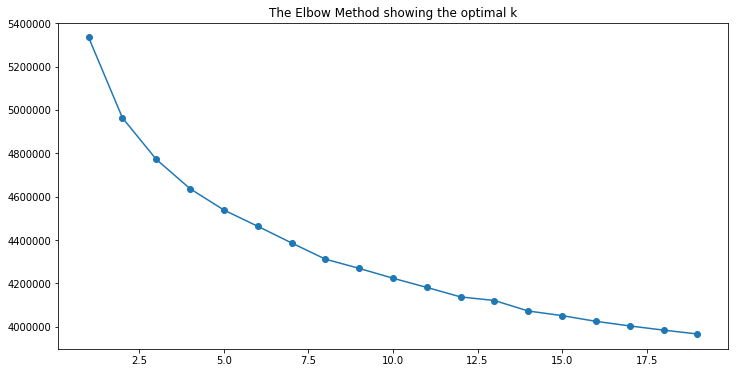

In [18]:
reg_train_result = []
reg_test_result = []
kmeans_n = []
for cluster in [3,5,10,15,20,25]:
    # Kmeans 실행
    X_kmeans = kmeans_united(cluster) 
    
    # 회귀분석 실행
    X_train, X_test, Y_train, Y_test = train_test_split(X_kmeans, y, test_size=0.3, random_state=5) 
    lm = LinearRegression()
    lm.fit(X_train,Y_train)
    Y_pred_train = lm.predict(X_train)
    Y_pred_test = lm.predict(X_test)
    
    # 결과저장
    kmeans_n.append(f'Kmeans_{cluster}')
    reg_train_result.append(str(np.sqrt(metrics.mean_squared_error(Y_train, Y_pred_train))))
    reg_test_result.append(str(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test))))

In [19]:
list_result = list(zip(kmeans_n, reg_train_result, reg_test_result))
result = pd.DataFrame(list_result, columns = ['kmeans_n', 'reg_train_result','reg_test_result'])
result

,kmeans_n,reg_train_result,reg_test_result
0,Kmeans_3,2832.709154421556,2761.962971209864
1,Kmeans_5,2790.471461699895,2725.300806756419
2,Kmeans_10,2790.0727171852254,2728.5963504172255
3,Kmeans_15,2700.614039211342,2654.105341443054
4,Kmeans_20,2675.819830323635,2627.7520060541633
5,Kmeans_25,2684.518942983769,2629.985562558695


#### SVD로 축소

SVD 참고 사이트 : https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.8-Singular-Value-Decomposition/

### 모델링
#### 선형회귀

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_cat_dummy, y, test_size=0.3, random_state=5)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

In [ ]:
lm = LinearRegression()
lm.fit(X_train,Y_train)
Y_pred_train = lm.predict(X_train)
Y_pred_test = lm.predict(X_test)

In [ ]:
#print('Training MSE is: ' + str(np.mean((Y_train - Y_pred_train)**2)))
#print('Testing MSE is: ' + str(np.mean((Y_test - Y_pred_test)**2)))
print('Training MSE is: ' + str(metrics.mean_squared_error(Y_train, Y_pred_train)))
print('Testing MSE is: ' + str(metrics.mean_squared_error(Y_test, Y_pred_test)))
print('-'*50)
print('Training RMSE is: ' + str(np.sqrt(metrics.mean_squared_error(Y_train, Y_pred_train))))
print('Testing RMSE is: ' + str(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test))))

In [ ]:
#pd.DataFrame(lm.coef_.reshape(-1,1), index = header,columns=['Value'])
pd.DataFrame(lm.coef_,index=['Value'],columns=header)